In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cpu


In [2]:
np.random.seed(1)

n_points = 500

y = np.concatenate((np.zeros(n_points),np.ones(n_points),np.ones(n_points)*2,np.ones(n_points)*3,np.ones(n_points)*4,
                    np.ones(n_points)*5,np.ones(n_points)*6,np.ones(n_points)*7,np.ones(n_points)*8,np.ones(n_points)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [3]:
x = np.zeros((n_points*10,2))

covariance_matrix = np.eye(2)*0.01 

np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],
                                            cov = covariance_matrix ,size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6]
                                            ,cov = covariance_matrix  ,size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],
                                            cov= covariance_matrix,size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],
                                            cov= covariance_matrix ,size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],
                                            cov= covariance_matrix,size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],
                                            cov=covariance_matrix,size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],
                                            cov= covariance_matrix,size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],
                                            cov=covariance_matrix,size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],
                                            cov=covariance_matrix,size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=
                                            covariance_matrix,size=sum(idx[9]))

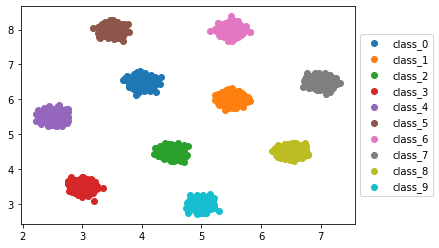

In [4]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
mean_x = np.mean(x,axis=0,keepdims=True)
std_x = np.std(x,axis=0,keepdims=True) 
x = ( x - mean_x  )  / std_x

In [6]:
x

array([[-0.46453639,  0.50682751],
       [-0.48097979,  0.4448011 ],
       [-0.44455458,  0.4549033 ],
       ...,
       [ 0.17640257, -1.61211362],
       [ 0.30756747, -1.58733936],
       [ 0.2088056 , -1.57732456]])

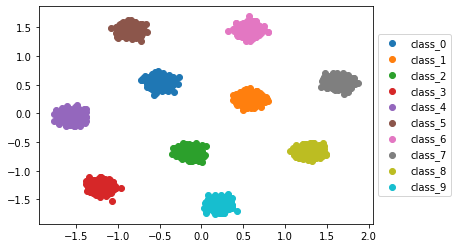

In [7]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
# bg_idx = [ np.where(idx[3] == True)[0], 
#           np.where(idx[4] == True)[0], 
#           np.where(idx[5] == True)[0],
#           np.where(idx[6] == True)[0], 
#           np.where(idx[7] == True)[0], 
#           np.where(idx[8] == True)[0],
#           np.where(idx[9] == True)[0]]

# bg_idx = np.concatenate(bg_idx, axis = 0)
# bg_idx.shape

In [9]:
# np.unique(bg_idx).shape

In [10]:
# x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)

In [11]:
# np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

In [12]:
# x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [13]:
# np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

In [14]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [15]:
desired_num = 1100  # 2000 + 1000


m = 100
dims = 2


mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx =  0 #np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,dims)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1100/1100 [00:02<00:00, 399.10it/s]


In [16]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number,m):
  """
  mosaic_dataset : mosaic_dataset contains 500 patches dimension 2 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/500 , bg_image_ratio = (500-j)/499*500
  """
  avg_image_dataset = []
  for i in tqdm(range(len(mosaic_dataset))):
    img = torch.zeros([2], dtype=torch.float64)
    for j in range(m):
      if j == foreground_index[i]:
        img = img + mosaic_dataset[i][j]*dataset_number/(m)
      else :
        img = img + mosaic_dataset[i][j]*(m-dataset_number)/((m-1)*(m))
    
    avg_image_dataset.append(img)
    
  return avg_image_dataset , labels , foreground_index

In [17]:
tr = 100

avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 1,m)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 10,m)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 20,m)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 30,m )
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 40,m)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 50,m)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] ,60,m)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 70,m)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 80,m)
avg_image_dataset_10 , labels_10,  fg_index_10 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 80,m)
avg_image_dataset_11 , labels_11,  fg_index_11 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 100,m)
avg_image_dataset_12 , labels_12,  fg_index_12= create_avg_image_from_mosaic_dataset(mosaic_list_of_images[tr:], mosaic_label[tr:], fore_idx[tr:] , 100,m)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 294.48it/s]


In [18]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1,dim=0)
avg_image_dataset_2 = torch.stack(avg_image_dataset_2,dim=0)
avg_image_dataset_3 = torch.stack(avg_image_dataset_3,dim=0)
avg_image_dataset_4 = torch.stack(avg_image_dataset_4,dim=0)
avg_image_dataset_5 = torch.stack(avg_image_dataset_5,dim=0)
avg_image_dataset_6 = torch.stack(avg_image_dataset_6,dim=0)
avg_image_dataset_7 = torch.stack(avg_image_dataset_7,dim=0)
avg_image_dataset_8 = torch.stack(avg_image_dataset_8,dim=0)
avg_image_dataset_9 = torch.stack(avg_image_dataset_9,dim=0)
avg_image_dataset_10 = torch.stack(avg_image_dataset_10,dim=0)
avg_image_dataset_11 = torch.stack(avg_image_dataset_11,dim=0)
avg_image_dataset_12 = torch.stack(avg_image_dataset_12,dim=0)

Text(0.5, 1.0, 'Dataset 12')

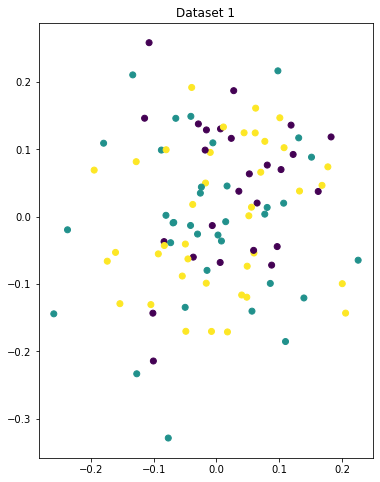

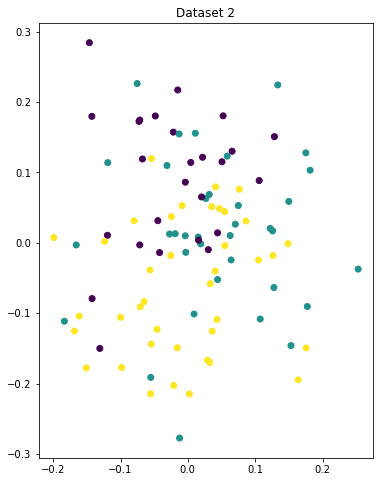

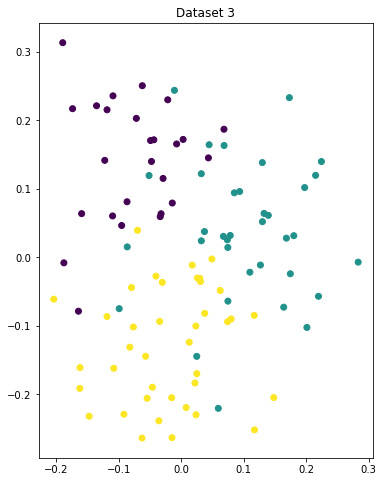

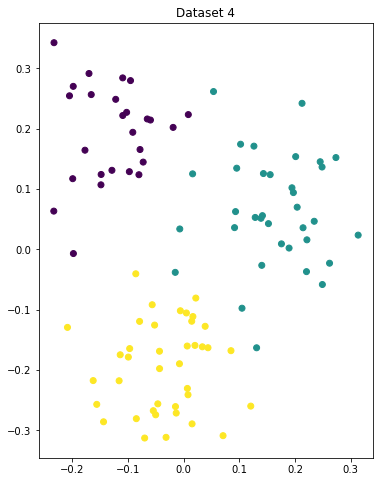

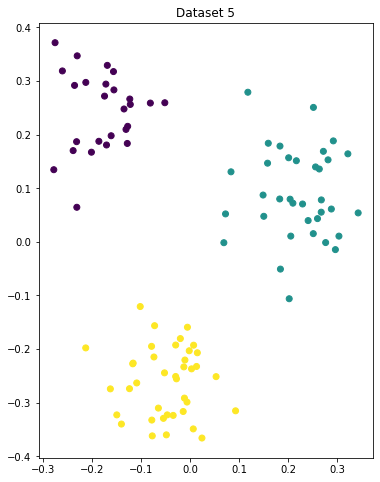

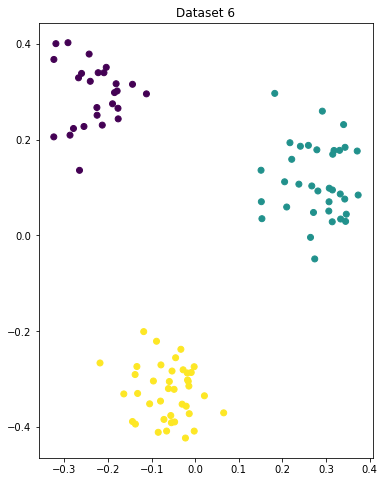

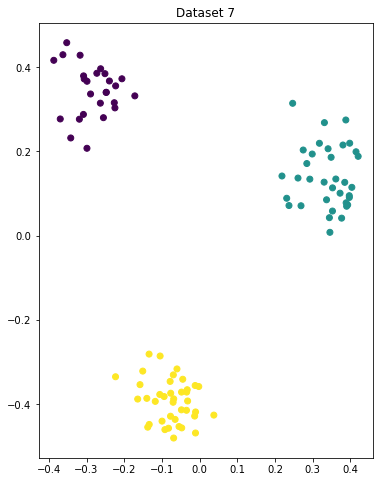

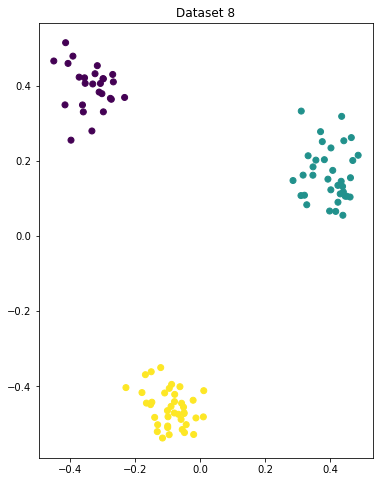

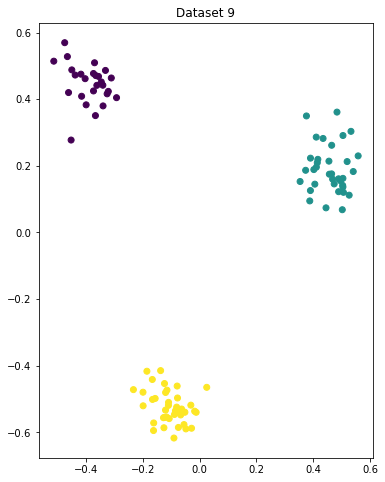

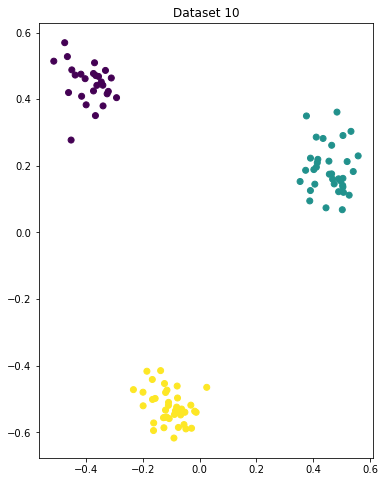

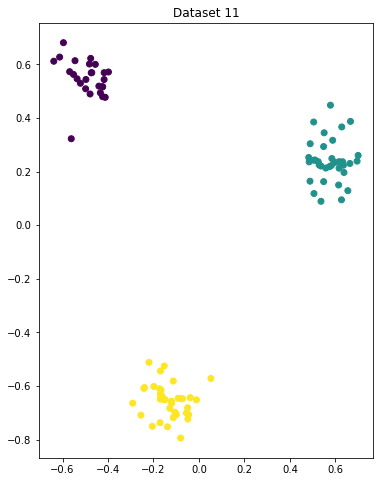

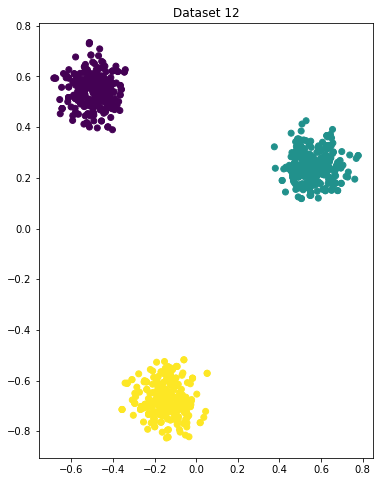

In [19]:
plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_1[:,0],avg_image_dataset_1[:,1],c=labels_1)
plt.title("Dataset 1")


plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_2[:,0],avg_image_dataset_2[:,1],c=labels_2)
plt.title("Dataset 2")



plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_3[:,0],avg_image_dataset_3[:,1],c=labels_3)
plt.title("Dataset 3")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_4[:,0],avg_image_dataset_4[:,1],c=labels_4)
plt.title("Dataset 4")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_5[:,0],avg_image_dataset_5[:,1],c=labels_5)
plt.title("Dataset 5")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_6[:,0],avg_image_dataset_6[:,1],c=labels_6)
plt.title("Dataset 6")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_7[:,0],avg_image_dataset_7[:,1],c=labels_7)
plt.title("Dataset 7")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_8[:,0],avg_image_dataset_8[:,1],c=labels_8)
plt.title("Dataset 8")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_9[:,0],avg_image_dataset_9[:,1],c=labels_9)
plt.title("Dataset 9")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_10[:,0],avg_image_dataset_10[:,1],c=labels_10)
plt.title("Dataset 10")


plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_11[:,0],avg_image_dataset_11[:,1],c=labels_11)
plt.title("Dataset 11")


plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_12[:,0],avg_image_dataset_12[:,1],c=labels_12)
plt.title("Dataset 12")

In [20]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [21]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)


traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

traindata_11 = MosaicDataset(avg_image_dataset_11, labels_11 )
trainloader_11 = DataLoader( traindata_11, batch_size= batch ,shuffle=True)



testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)


testdata_11 = MosaicDataset(avg_image_dataset_11, labels_11)
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)


testdata_12 = MosaicDataset(avg_image_dataset_12, labels_12)
testloader_12 = DataLoader( testdata_12 , batch_size= batch ,shuffle=False)



mosaicdata = MosaicDataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr] )
mosaicloader = DataLoader( mosaicdata , batch_size= batch ,shuffle=True)


In [22]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.zeros_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
  def forward(self, x):
    x = self.fc1(x)
    # print(x.shape)
    return x

In [23]:
torch.manual_seed(12)
net = Net()

In [24]:
for params in net.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


In [25]:
def calculate_loss_alpha(mosaic_loader,alpha_,net,loss_criterion):
    m = 100
    
    loss = []
    with torch.no_grad():
        for i,data in enumerate(mosaic_loader):
            inputs,target =data

            batch = inputs.size(0)
            #print(batch)
            patches = inputs.size(1)
            dims = inputs.size(2)
            
            
            data_weight = torch.ones((batch,patches,dims))*((1-alpha_)/(m-1))
            
            
            data_weight[:,0,:] = torch.ones((batch,dims))*alpha_
            
            
            #print(data_weight[0])
        
            
            data = torch.mul(data_weight,inputs)
            
            data_new = torch.zeros((batch,dims))
            for i in range(len(data)):
                data_new[i,:] = torch.sum(data[i],dim=0) 
            #print(data_new)
            outputs = net(data_new.double())
            loss_ = loss_criterion(outputs,target)
            loss.append(loss_.item())
    return np.mean(loss)

In [26]:
# torch.manual_seed(12)
# net = Net().double()
# net = net.to(device)
# criterion = nn.CrossEntropyLoss()
# calculate_loss_alpha(mosaicloader,0,net,criterion)

In [27]:
def calculate_loss(trainloader,net,criterion):
    running_loss = 0.0
    ep_lossi = []
    with torch.no_grad():
        for k, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            ep_lossi.append(running_loss)
    return np.mean(ep_lossi)
         

In [28]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [29]:
def train_all(trainloader, ds_number, testloader_list,mosaicloader,alpha):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)#, momentum=0.9)
    
    acti = []
    loss_curi = []
    loss_alpha_h_curi = []
    epochs = 1000
    
    
    criterion_ = nn.CrossEntropyLoss()
    if alpha == 1.0:
        print("alpha is", alpha)
        alpha_ = alpha
    else:
        alpha_ = alpha+0.01
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        if epoch ==0:
                loss_curi.append(calculate_loss(trainloader,net,criterion))
        loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 1
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(calculate_loss(trainloader,net,criterion))   #loss per epoch
    print('Finished Training')
    loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
    
    
    #torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi,loss_alpha_h_curi


In [30]:
train_loss_all=[]
train_loss_alpha_h_all = []

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10,testloader_11,testloader_12]

temp1,temp2 = train_all(trainloader_1, 1, testloader_list,mosaicloader,1/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_2, 2, testloader_list,mosaicloader,10/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_3, 3, testloader_list,mosaicloader,20/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_4, 4, testloader_list,mosaicloader,30/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_5, 5, testloader_list,mosaicloader,40/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_6, 6, testloader_list,mosaicloader,50/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_7, 7, testloader_list,mosaicloader,60/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_8, 8, testloader_list,mosaicloader,70/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_9, 9, testloader_list,mosaicloader,80/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_10, 10, testloader_list,mosaicloader,90/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_11, 11, testloader_list,mosaicloader,100/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

--------------------------------------------------------------------------------
training on data set   1
[1,     1] loss: 1.099
[2,     1] loss: 1.097
[3,     1] loss: 1.095
[4,     1] loss: 1.094
[5,     1] loss: 1.092
[6,     1] loss: 1.091
[7,     1] loss: 1.090
[8,     1] loss: 1.089
[9,     1] loss: 1.087
[10,     1] loss: 1.086
[11,     1] loss: 1.086
[12,     1] loss: 1.085
[13,     1] loss: 1.084
[14,     1] loss: 1.083
[15,     1] loss: 1.082
[16,     1] loss: 1.082
[17,     1] loss: 1.081
[18,     1] loss: 1.081
[19,     1] loss: 1.080
[20,     1] loss: 1.080
[21,     1] loss: 1.079
[22,     1] loss: 1.079
[23,     1] loss: 1.079
[24,     1] loss: 1.078
[25,     1] loss: 1.078
[26,     1] loss: 1.078
[27,     1] loss: 1.078
[28,     1] loss: 1.078
[29,     1] loss: 1.077
[30,     1] loss: 1.077
[31,     1] loss: 1.077
[32,     1] loss: 1.077
[33,     1] loss: 1.076
[34,     1] loss: 1.076
[35,     1] loss: 1.076
[36,     1] loss: 1.076
[37,     1] loss: 1.076
[38,     1] los

[389,     1] loss: 1.057
[390,     1] loss: 1.057
[391,     1] loss: 1.057
[392,     1] loss: 1.057
[393,     1] loss: 1.057
[394,     1] loss: 1.057
[395,     1] loss: 1.057
[396,     1] loss: 1.057
[397,     1] loss: 1.057
[398,     1] loss: 1.057
[399,     1] loss: 1.057
[400,     1] loss: 1.057
[401,     1] loss: 1.057
[402,     1] loss: 1.057
[403,     1] loss: 1.057
[404,     1] loss: 1.057
[405,     1] loss: 1.057
[406,     1] loss: 1.057
[407,     1] loss: 1.057
[408,     1] loss: 1.057
[409,     1] loss: 1.057
[410,     1] loss: 1.057
[411,     1] loss: 1.057
[412,     1] loss: 1.057
[413,     1] loss: 1.057
[414,     1] loss: 1.057
[415,     1] loss: 1.057
[416,     1] loss: 1.057
[417,     1] loss: 1.057
[418,     1] loss: 1.057
[419,     1] loss: 1.057
[420,     1] loss: 1.057
[421,     1] loss: 1.057
[422,     1] loss: 1.057
[423,     1] loss: 1.057
[424,     1] loss: 1.057
[425,     1] loss: 1.057
[426,     1] loss: 1.057
[427,     1] loss: 1.057
[428,     1] loss: 1.057


[739,     1] loss: 1.057
[740,     1] loss: 1.057
[741,     1] loss: 1.057
[742,     1] loss: 1.057
[743,     1] loss: 1.057
[744,     1] loss: 1.057
[745,     1] loss: 1.057
[746,     1] loss: 1.057
[747,     1] loss: 1.057
[748,     1] loss: 1.057
[749,     1] loss: 1.057
[750,     1] loss: 1.057
[751,     1] loss: 1.057
[752,     1] loss: 1.057
[753,     1] loss: 1.057
[754,     1] loss: 1.057
[755,     1] loss: 1.057
[756,     1] loss: 1.057
[757,     1] loss: 1.057
[758,     1] loss: 1.057
[759,     1] loss: 1.057
[760,     1] loss: 1.057
[761,     1] loss: 1.057
[762,     1] loss: 1.057
[763,     1] loss: 1.057
[764,     1] loss: 1.057
[765,     1] loss: 1.057
[766,     1] loss: 1.057
[767,     1] loss: 1.057
[768,     1] loss: 1.057
[769,     1] loss: 1.057
[770,     1] loss: 1.057
[771,     1] loss: 1.057
[772,     1] loss: 1.057
[773,     1] loss: 1.057
[774,     1] loss: 1.057
[775,     1] loss: 1.057
[776,     1] loss: 1.057
[777,     1] loss: 1.057
[778,     1] loss: 1.057


[85,     1] loss: 1.029
[86,     1] loss: 1.029
[87,     1] loss: 1.028
[88,     1] loss: 1.028
[89,     1] loss: 1.027
[90,     1] loss: 1.027
[91,     1] loss: 1.026
[92,     1] loss: 1.026
[93,     1] loss: 1.025
[94,     1] loss: 1.025
[95,     1] loss: 1.024
[96,     1] loss: 1.023
[97,     1] loss: 1.023
[98,     1] loss: 1.022
[99,     1] loss: 1.022
[100,     1] loss: 1.021
[101,     1] loss: 1.021
[102,     1] loss: 1.020
[103,     1] loss: 1.020
[104,     1] loss: 1.019
[105,     1] loss: 1.019
[106,     1] loss: 1.018
[107,     1] loss: 1.018
[108,     1] loss: 1.017
[109,     1] loss: 1.017
[110,     1] loss: 1.016
[111,     1] loss: 1.016
[112,     1] loss: 1.015
[113,     1] loss: 1.015
[114,     1] loss: 1.014
[115,     1] loss: 1.014
[116,     1] loss: 1.013
[117,     1] loss: 1.013
[118,     1] loss: 1.012
[119,     1] loss: 1.012
[120,     1] loss: 1.011
[121,     1] loss: 1.011
[122,     1] loss: 1.010
[123,     1] loss: 1.010
[124,     1] loss: 1.010
[125,     1] lo

[437,     1] loss: 0.924
[438,     1] loss: 0.924
[439,     1] loss: 0.924
[440,     1] loss: 0.924
[441,     1] loss: 0.924
[442,     1] loss: 0.924
[443,     1] loss: 0.923
[444,     1] loss: 0.923
[445,     1] loss: 0.923
[446,     1] loss: 0.923
[447,     1] loss: 0.923
[448,     1] loss: 0.923
[449,     1] loss: 0.923
[450,     1] loss: 0.922
[451,     1] loss: 0.922
[452,     1] loss: 0.922
[453,     1] loss: 0.922
[454,     1] loss: 0.922
[455,     1] loss: 0.922
[456,     1] loss: 0.922
[457,     1] loss: 0.922
[458,     1] loss: 0.921
[459,     1] loss: 0.921
[460,     1] loss: 0.921
[461,     1] loss: 0.921
[462,     1] loss: 0.921
[463,     1] loss: 0.921
[464,     1] loss: 0.921
[465,     1] loss: 0.920
[466,     1] loss: 0.920
[467,     1] loss: 0.920
[468,     1] loss: 0.920
[469,     1] loss: 0.920
[470,     1] loss: 0.920
[471,     1] loss: 0.920
[472,     1] loss: 0.920
[473,     1] loss: 0.919
[474,     1] loss: 0.919
[475,     1] loss: 0.919
[476,     1] loss: 0.919


[793,     1] loss: 0.896
[794,     1] loss: 0.896
[795,     1] loss: 0.896
[796,     1] loss: 0.896
[797,     1] loss: 0.896
[798,     1] loss: 0.896
[799,     1] loss: 0.896
[800,     1] loss: 0.896
[801,     1] loss: 0.896
[802,     1] loss: 0.896
[803,     1] loss: 0.896
[804,     1] loss: 0.896
[805,     1] loss: 0.896
[806,     1] loss: 0.896
[807,     1] loss: 0.896
[808,     1] loss: 0.896
[809,     1] loss: 0.896
[810,     1] loss: 0.896
[811,     1] loss: 0.896
[812,     1] loss: 0.896
[813,     1] loss: 0.895
[814,     1] loss: 0.895
[815,     1] loss: 0.895
[816,     1] loss: 0.895
[817,     1] loss: 0.895
[818,     1] loss: 0.895
[819,     1] loss: 0.895
[820,     1] loss: 0.895
[821,     1] loss: 0.895
[822,     1] loss: 0.895
[823,     1] loss: 0.895
[824,     1] loss: 0.895
[825,     1] loss: 0.895
[826,     1] loss: 0.895
[827,     1] loss: 0.895
[828,     1] loss: 0.895
[829,     1] loss: 0.895
[830,     1] loss: 0.895
[831,     1] loss: 0.895
[832,     1] loss: 0.895


[142,     1] loss: 0.889
[143,     1] loss: 0.888
[144,     1] loss: 0.887
[145,     1] loss: 0.886
[146,     1] loss: 0.885
[147,     1] loss: 0.884
[148,     1] loss: 0.882
[149,     1] loss: 0.881
[150,     1] loss: 0.880
[151,     1] loss: 0.879
[152,     1] loss: 0.878
[153,     1] loss: 0.877
[154,     1] loss: 0.876
[155,     1] loss: 0.875
[156,     1] loss: 0.874
[157,     1] loss: 0.873
[158,     1] loss: 0.872
[159,     1] loss: 0.870
[160,     1] loss: 0.869
[161,     1] loss: 0.868
[162,     1] loss: 0.867
[163,     1] loss: 0.866
[164,     1] loss: 0.865
[165,     1] loss: 0.864
[166,     1] loss: 0.863
[167,     1] loss: 0.862
[168,     1] loss: 0.861
[169,     1] loss: 0.860
[170,     1] loss: 0.859
[171,     1] loss: 0.858
[172,     1] loss: 0.857
[173,     1] loss: 0.856
[174,     1] loss: 0.855
[175,     1] loss: 0.854
[176,     1] loss: 0.853
[177,     1] loss: 0.852
[178,     1] loss: 0.851
[179,     1] loss: 0.850
[180,     1] loss: 0.849
[181,     1] loss: 0.848


[498,     1] loss: 0.635
[499,     1] loss: 0.635
[500,     1] loss: 0.635
[501,     1] loss: 0.634
[502,     1] loss: 0.634
[503,     1] loss: 0.633
[504,     1] loss: 0.633
[505,     1] loss: 0.633
[506,     1] loss: 0.632
[507,     1] loss: 0.632
[508,     1] loss: 0.631
[509,     1] loss: 0.631
[510,     1] loss: 0.630
[511,     1] loss: 0.630
[512,     1] loss: 0.630
[513,     1] loss: 0.629
[514,     1] loss: 0.629
[515,     1] loss: 0.628
[516,     1] loss: 0.628
[517,     1] loss: 0.628
[518,     1] loss: 0.627
[519,     1] loss: 0.627
[520,     1] loss: 0.626
[521,     1] loss: 0.626
[522,     1] loss: 0.625
[523,     1] loss: 0.625
[524,     1] loss: 0.625
[525,     1] loss: 0.624
[526,     1] loss: 0.624
[527,     1] loss: 0.623
[528,     1] loss: 0.623
[529,     1] loss: 0.623
[530,     1] loss: 0.622
[531,     1] loss: 0.622
[532,     1] loss: 0.622
[533,     1] loss: 0.621
[534,     1] loss: 0.621
[535,     1] loss: 0.620
[536,     1] loss: 0.620
[537,     1] loss: 0.620


[851,     1] loss: 0.532
[852,     1] loss: 0.531
[853,     1] loss: 0.531
[854,     1] loss: 0.531
[855,     1] loss: 0.531
[856,     1] loss: 0.531
[857,     1] loss: 0.530
[858,     1] loss: 0.530
[859,     1] loss: 0.530
[860,     1] loss: 0.530
[861,     1] loss: 0.530
[862,     1] loss: 0.530
[863,     1] loss: 0.529
[864,     1] loss: 0.529
[865,     1] loss: 0.529
[866,     1] loss: 0.529
[867,     1] loss: 0.529
[868,     1] loss: 0.528
[869,     1] loss: 0.528
[870,     1] loss: 0.528
[871,     1] loss: 0.528
[872,     1] loss: 0.528
[873,     1] loss: 0.527
[874,     1] loss: 0.527
[875,     1] loss: 0.527
[876,     1] loss: 0.527
[877,     1] loss: 0.527
[878,     1] loss: 0.526
[879,     1] loss: 0.526
[880,     1] loss: 0.526
[881,     1] loss: 0.526
[882,     1] loss: 0.526
[883,     1] loss: 0.526
[884,     1] loss: 0.525
[885,     1] loss: 0.525
[886,     1] loss: 0.525
[887,     1] loss: 0.525
[888,     1] loss: 0.525
[889,     1] loss: 0.524
[890,     1] loss: 0.524


[196,     1] loss: 0.704
[197,     1] loss: 0.703
[198,     1] loss: 0.701
[199,     1] loss: 0.700
[200,     1] loss: 0.698
[201,     1] loss: 0.697
[202,     1] loss: 0.696
[203,     1] loss: 0.694
[204,     1] loss: 0.693
[205,     1] loss: 0.691
[206,     1] loss: 0.690
[207,     1] loss: 0.689
[208,     1] loss: 0.687
[209,     1] loss: 0.686
[210,     1] loss: 0.685
[211,     1] loss: 0.683
[212,     1] loss: 0.682
[213,     1] loss: 0.681
[214,     1] loss: 0.679
[215,     1] loss: 0.678
[216,     1] loss: 0.676
[217,     1] loss: 0.675
[218,     1] loss: 0.674
[219,     1] loss: 0.673
[220,     1] loss: 0.671
[221,     1] loss: 0.670
[222,     1] loss: 0.669
[223,     1] loss: 0.667
[224,     1] loss: 0.666
[225,     1] loss: 0.665
[226,     1] loss: 0.663
[227,     1] loss: 0.662
[228,     1] loss: 0.661
[229,     1] loss: 0.660
[230,     1] loss: 0.658
[231,     1] loss: 0.657
[232,     1] loss: 0.656
[233,     1] loss: 0.654
[234,     1] loss: 0.653
[235,     1] loss: 0.652


[549,     1] loss: 0.395
[550,     1] loss: 0.395
[551,     1] loss: 0.394
[552,     1] loss: 0.394
[553,     1] loss: 0.393
[554,     1] loss: 0.393
[555,     1] loss: 0.392
[556,     1] loss: 0.392
[557,     1] loss: 0.391
[558,     1] loss: 0.391
[559,     1] loss: 0.390
[560,     1] loss: 0.390
[561,     1] loss: 0.389
[562,     1] loss: 0.389
[563,     1] loss: 0.388
[564,     1] loss: 0.388
[565,     1] loss: 0.387
[566,     1] loss: 0.387
[567,     1] loss: 0.386
[568,     1] loss: 0.386
[569,     1] loss: 0.385
[570,     1] loss: 0.385
[571,     1] loss: 0.384
[572,     1] loss: 0.384
[573,     1] loss: 0.383
[574,     1] loss: 0.383
[575,     1] loss: 0.382
[576,     1] loss: 0.382
[577,     1] loss: 0.382
[578,     1] loss: 0.381
[579,     1] loss: 0.381
[580,     1] loss: 0.380
[581,     1] loss: 0.380
[582,     1] loss: 0.379
[583,     1] loss: 0.379
[584,     1] loss: 0.378
[585,     1] loss: 0.378
[586,     1] loss: 0.377
[587,     1] loss: 0.377
[588,     1] loss: 0.376


[903,     1] loss: 0.271
[904,     1] loss: 0.271
[905,     1] loss: 0.271
[906,     1] loss: 0.270
[907,     1] loss: 0.270
[908,     1] loss: 0.270
[909,     1] loss: 0.270
[910,     1] loss: 0.270
[911,     1] loss: 0.269
[912,     1] loss: 0.269
[913,     1] loss: 0.269
[914,     1] loss: 0.269
[915,     1] loss: 0.268
[916,     1] loss: 0.268
[917,     1] loss: 0.268
[918,     1] loss: 0.268
[919,     1] loss: 0.267
[920,     1] loss: 0.267
[921,     1] loss: 0.267
[922,     1] loss: 0.267
[923,     1] loss: 0.267
[924,     1] loss: 0.266
[925,     1] loss: 0.266
[926,     1] loss: 0.266
[927,     1] loss: 0.266
[928,     1] loss: 0.265
[929,     1] loss: 0.265
[930,     1] loss: 0.265
[931,     1] loss: 0.265
[932,     1] loss: 0.264
[933,     1] loss: 0.264
[934,     1] loss: 0.264
[935,     1] loss: 0.264
[936,     1] loss: 0.264
[937,     1] loss: 0.263
[938,     1] loss: 0.263
[939,     1] loss: 0.263
[940,     1] loss: 0.263
[941,     1] loss: 0.262
[942,     1] loss: 0.262


[251,     1] loss: 0.512
[252,     1] loss: 0.511
[253,     1] loss: 0.510
[254,     1] loss: 0.508
[255,     1] loss: 0.507
[256,     1] loss: 0.506
[257,     1] loss: 0.504
[258,     1] loss: 0.503
[259,     1] loss: 0.502
[260,     1] loss: 0.500
[261,     1] loss: 0.499
[262,     1] loss: 0.498
[263,     1] loss: 0.496
[264,     1] loss: 0.495
[265,     1] loss: 0.494
[266,     1] loss: 0.492
[267,     1] loss: 0.491
[268,     1] loss: 0.490
[269,     1] loss: 0.489
[270,     1] loss: 0.487
[271,     1] loss: 0.486
[272,     1] loss: 0.485
[273,     1] loss: 0.484
[274,     1] loss: 0.482
[275,     1] loss: 0.481
[276,     1] loss: 0.480
[277,     1] loss: 0.479
[278,     1] loss: 0.477
[279,     1] loss: 0.476
[280,     1] loss: 0.475
[281,     1] loss: 0.474
[282,     1] loss: 0.472
[283,     1] loss: 0.471
[284,     1] loss: 0.470
[285,     1] loss: 0.469
[286,     1] loss: 0.468
[287,     1] loss: 0.466
[288,     1] loss: 0.465
[289,     1] loss: 0.464
[290,     1] loss: 0.463


[605,     1] loss: 0.237
[606,     1] loss: 0.237
[607,     1] loss: 0.236
[608,     1] loss: 0.236
[609,     1] loss: 0.236
[610,     1] loss: 0.235
[611,     1] loss: 0.235
[612,     1] loss: 0.234
[613,     1] loss: 0.234
[614,     1] loss: 0.233
[615,     1] loss: 0.233
[616,     1] loss: 0.233
[617,     1] loss: 0.232
[618,     1] loss: 0.232
[619,     1] loss: 0.231
[620,     1] loss: 0.231
[621,     1] loss: 0.231
[622,     1] loss: 0.230
[623,     1] loss: 0.230
[624,     1] loss: 0.229
[625,     1] loss: 0.229
[626,     1] loss: 0.229
[627,     1] loss: 0.228
[628,     1] loss: 0.228
[629,     1] loss: 0.228
[630,     1] loss: 0.227
[631,     1] loss: 0.227
[632,     1] loss: 0.226
[633,     1] loss: 0.226
[634,     1] loss: 0.226
[635,     1] loss: 0.225
[636,     1] loss: 0.225
[637,     1] loss: 0.224
[638,     1] loss: 0.224
[639,     1] loss: 0.224
[640,     1] loss: 0.223
[641,     1] loss: 0.223
[642,     1] loss: 0.223
[643,     1] loss: 0.222
[644,     1] loss: 0.222


[957,     1] loss: 0.141
[958,     1] loss: 0.141
[959,     1] loss: 0.140
[960,     1] loss: 0.140
[961,     1] loss: 0.140
[962,     1] loss: 0.140
[963,     1] loss: 0.140
[964,     1] loss: 0.140
[965,     1] loss: 0.139
[966,     1] loss: 0.139
[967,     1] loss: 0.139
[968,     1] loss: 0.139
[969,     1] loss: 0.139
[970,     1] loss: 0.139
[971,     1] loss: 0.138
[972,     1] loss: 0.138
[973,     1] loss: 0.138
[974,     1] loss: 0.138
[975,     1] loss: 0.138
[976,     1] loss: 0.138
[977,     1] loss: 0.137
[978,     1] loss: 0.137
[979,     1] loss: 0.137
[980,     1] loss: 0.137
[981,     1] loss: 0.137
[982,     1] loss: 0.137
[983,     1] loss: 0.136
[984,     1] loss: 0.136
[985,     1] loss: 0.136
[986,     1] loss: 0.136
[987,     1] loss: 0.136
[988,     1] loss: 0.136
[989,     1] loss: 0.135
[990,     1] loss: 0.135
[991,     1] loss: 0.135
[992,     1] loss: 0.135
[993,     1] loss: 0.135
[994,     1] loss: 0.135
[995,     1] loss: 0.134
[996,     1] loss: 0.134


[302,     1] loss: 0.356
[303,     1] loss: 0.354
[304,     1] loss: 0.353
[305,     1] loss: 0.352
[306,     1] loss: 0.351
[307,     1] loss: 0.350
[308,     1] loss: 0.349
[309,     1] loss: 0.348
[310,     1] loss: 0.347
[311,     1] loss: 0.346
[312,     1] loss: 0.345
[313,     1] loss: 0.344
[314,     1] loss: 0.343
[315,     1] loss: 0.342
[316,     1] loss: 0.341
[317,     1] loss: 0.340
[318,     1] loss: 0.338
[319,     1] loss: 0.337
[320,     1] loss: 0.336
[321,     1] loss: 0.335
[322,     1] loss: 0.334
[323,     1] loss: 0.333
[324,     1] loss: 0.332
[325,     1] loss: 0.331
[326,     1] loss: 0.330
[327,     1] loss: 0.329
[328,     1] loss: 0.328
[329,     1] loss: 0.327
[330,     1] loss: 0.326
[331,     1] loss: 0.325
[332,     1] loss: 0.324
[333,     1] loss: 0.323
[334,     1] loss: 0.323
[335,     1] loss: 0.322
[336,     1] loss: 0.321
[337,     1] loss: 0.320
[338,     1] loss: 0.319
[339,     1] loss: 0.318
[340,     1] loss: 0.317
[341,     1] loss: 0.316


[655,     1] loss: 0.148
[656,     1] loss: 0.147
[657,     1] loss: 0.147
[658,     1] loss: 0.147
[659,     1] loss: 0.146
[660,     1] loss: 0.146
[661,     1] loss: 0.146
[662,     1] loss: 0.146
[663,     1] loss: 0.145
[664,     1] loss: 0.145
[665,     1] loss: 0.145
[666,     1] loss: 0.144
[667,     1] loss: 0.144
[668,     1] loss: 0.144
[669,     1] loss: 0.144
[670,     1] loss: 0.143
[671,     1] loss: 0.143
[672,     1] loss: 0.143
[673,     1] loss: 0.142
[674,     1] loss: 0.142
[675,     1] loss: 0.142
[676,     1] loss: 0.142
[677,     1] loss: 0.141
[678,     1] loss: 0.141
[679,     1] loss: 0.141
[680,     1] loss: 0.140
[681,     1] loss: 0.140
[682,     1] loss: 0.140
[683,     1] loss: 0.140
[684,     1] loss: 0.139
[685,     1] loss: 0.139
[686,     1] loss: 0.139
[687,     1] loss: 0.139
[688,     1] loss: 0.138
[689,     1] loss: 0.138
[690,     1] loss: 0.138
[691,     1] loss: 0.138
[692,     1] loss: 0.137
[693,     1] loss: 0.137
[694,     1] loss: 0.137


Accuracy of the network on the train images: 100 %
Accuracy of the network on the test dataset 1: 32 %
Accuracy of the network on the test dataset 2: 53 %
Accuracy of the network on the test dataset 3: 86 %
Accuracy of the network on the test dataset 4: 97 %
Accuracy of the network on the test dataset 5: 100 %
Accuracy of the network on the test dataset 6: 100 %
Accuracy of the network on the test dataset 7: 100 %
Accuracy of the network on the test dataset 8: 100 %
Accuracy of the network on the test dataset 9: 100 %
Accuracy of the network on the test dataset 10: 100 %
Accuracy of the network on the test dataset 11: 100 %
Accuracy of the network on the test dataset 12: 100 %
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
training on data set   7
[1,     1] loss: 1.099
[2,     1] loss: 1.092
[3,     1] loss: 1.085
[4,     1] loss: 1.079
[5,     1] loss: 1.073
[6,     1] l

[346,     1] loss: 0.246
[347,     1] loss: 0.246
[348,     1] loss: 0.245
[349,     1] loss: 0.244
[350,     1] loss: 0.243
[351,     1] loss: 0.242
[352,     1] loss: 0.242
[353,     1] loss: 0.241
[354,     1] loss: 0.240
[355,     1] loss: 0.239
[356,     1] loss: 0.238
[357,     1] loss: 0.238
[358,     1] loss: 0.237
[359,     1] loss: 0.236
[360,     1] loss: 0.235
[361,     1] loss: 0.235
[362,     1] loss: 0.234
[363,     1] loss: 0.233
[364,     1] loss: 0.232
[365,     1] loss: 0.231
[366,     1] loss: 0.231
[367,     1] loss: 0.230
[368,     1] loss: 0.229
[369,     1] loss: 0.228
[370,     1] loss: 0.228
[371,     1] loss: 0.227
[372,     1] loss: 0.226
[373,     1] loss: 0.226
[374,     1] loss: 0.225
[375,     1] loss: 0.224
[376,     1] loss: 0.223
[377,     1] loss: 0.223
[378,     1] loss: 0.222
[379,     1] loss: 0.221
[380,     1] loss: 0.221
[381,     1] loss: 0.220
[382,     1] loss: 0.219
[383,     1] loss: 0.219
[384,     1] loss: 0.218
[385,     1] loss: 0.217


[694,     1] loss: 0.099
[695,     1] loss: 0.099
[696,     1] loss: 0.099
[697,     1] loss: 0.098
[698,     1] loss: 0.098
[699,     1] loss: 0.098
[700,     1] loss: 0.098
[701,     1] loss: 0.098
[702,     1] loss: 0.097
[703,     1] loss: 0.097
[704,     1] loss: 0.097
[705,     1] loss: 0.097
[706,     1] loss: 0.097
[707,     1] loss: 0.096
[708,     1] loss: 0.096
[709,     1] loss: 0.096
[710,     1] loss: 0.096
[711,     1] loss: 0.096
[712,     1] loss: 0.095
[713,     1] loss: 0.095
[714,     1] loss: 0.095
[715,     1] loss: 0.095
[716,     1] loss: 0.095
[717,     1] loss: 0.094
[718,     1] loss: 0.094
[719,     1] loss: 0.094
[720,     1] loss: 0.094
[721,     1] loss: 0.094
[722,     1] loss: 0.093
[723,     1] loss: 0.093
[724,     1] loss: 0.093
[725,     1] loss: 0.093
[726,     1] loss: 0.093
[727,     1] loss: 0.093
[728,     1] loss: 0.092
[729,     1] loss: 0.092
[730,     1] loss: 0.092
[731,     1] loss: 0.092
[732,     1] loss: 0.092
[733,     1] loss: 0.091


[41,     1] loss: 0.862
[42,     1] loss: 0.857
[43,     1] loss: 0.852
[44,     1] loss: 0.847
[45,     1] loss: 0.842
[46,     1] loss: 0.838
[47,     1] loss: 0.833
[48,     1] loss: 0.828
[49,     1] loss: 0.823
[50,     1] loss: 0.818
[51,     1] loss: 0.814
[52,     1] loss: 0.809
[53,     1] loss: 0.804
[54,     1] loss: 0.800
[55,     1] loss: 0.795
[56,     1] loss: 0.790
[57,     1] loss: 0.786
[58,     1] loss: 0.781
[59,     1] loss: 0.777
[60,     1] loss: 0.772
[61,     1] loss: 0.768
[62,     1] loss: 0.764
[63,     1] loss: 0.759
[64,     1] loss: 0.755
[65,     1] loss: 0.751
[66,     1] loss: 0.746
[67,     1] loss: 0.742
[68,     1] loss: 0.738
[69,     1] loss: 0.734
[70,     1] loss: 0.729
[71,     1] loss: 0.725
[72,     1] loss: 0.721
[73,     1] loss: 0.717
[74,     1] loss: 0.713
[75,     1] loss: 0.709
[76,     1] loss: 0.705
[77,     1] loss: 0.701
[78,     1] loss: 0.697
[79,     1] loss: 0.693
[80,     1] loss: 0.689
[81,     1] loss: 0.685
[82,     1] loss

[384,     1] loss: 0.175
[385,     1] loss: 0.174
[386,     1] loss: 0.174
[387,     1] loss: 0.173
[388,     1] loss: 0.173
[389,     1] loss: 0.172
[390,     1] loss: 0.171
[391,     1] loss: 0.171
[392,     1] loss: 0.170
[393,     1] loss: 0.170
[394,     1] loss: 0.169
[395,     1] loss: 0.169
[396,     1] loss: 0.168
[397,     1] loss: 0.167
[398,     1] loss: 0.167
[399,     1] loss: 0.166
[400,     1] loss: 0.166
[401,     1] loss: 0.165
[402,     1] loss: 0.165
[403,     1] loss: 0.164
[404,     1] loss: 0.164
[405,     1] loss: 0.163
[406,     1] loss: 0.163
[407,     1] loss: 0.162
[408,     1] loss: 0.162
[409,     1] loss: 0.161
[410,     1] loss: 0.161
[411,     1] loss: 0.160
[412,     1] loss: 0.159
[413,     1] loss: 0.159
[414,     1] loss: 0.158
[415,     1] loss: 0.158
[416,     1] loss: 0.157
[417,     1] loss: 0.157
[418,     1] loss: 0.156
[419,     1] loss: 0.156
[420,     1] loss: 0.155
[421,     1] loss: 0.155
[422,     1] loss: 0.154
[423,     1] loss: 0.154


[738,     1] loss: 0.069
[739,     1] loss: 0.069
[740,     1] loss: 0.069
[741,     1] loss: 0.069
[742,     1] loss: 0.069
[743,     1] loss: 0.069
[744,     1] loss: 0.068
[745,     1] loss: 0.068
[746,     1] loss: 0.068
[747,     1] loss: 0.068
[748,     1] loss: 0.068
[749,     1] loss: 0.068
[750,     1] loss: 0.068
[751,     1] loss: 0.067
[752,     1] loss: 0.067
[753,     1] loss: 0.067
[754,     1] loss: 0.067
[755,     1] loss: 0.067
[756,     1] loss: 0.067
[757,     1] loss: 0.067
[758,     1] loss: 0.066
[759,     1] loss: 0.066
[760,     1] loss: 0.066
[761,     1] loss: 0.066
[762,     1] loss: 0.066
[763,     1] loss: 0.066
[764,     1] loss: 0.066
[765,     1] loss: 0.066
[766,     1] loss: 0.065
[767,     1] loss: 0.065
[768,     1] loss: 0.065
[769,     1] loss: 0.065
[770,     1] loss: 0.065
[771,     1] loss: 0.065
[772,     1] loss: 0.065
[773,     1] loss: 0.065
[774,     1] loss: 0.064
[775,     1] loss: 0.064
[776,     1] loss: 0.064
[777,     1] loss: 0.064


[87,     1] loss: 0.616
[88,     1] loss: 0.612
[89,     1] loss: 0.608
[90,     1] loss: 0.604
[91,     1] loss: 0.600
[92,     1] loss: 0.597
[93,     1] loss: 0.593
[94,     1] loss: 0.589
[95,     1] loss: 0.585
[96,     1] loss: 0.582
[97,     1] loss: 0.578
[98,     1] loss: 0.574
[99,     1] loss: 0.571
[100,     1] loss: 0.567
[101,     1] loss: 0.564
[102,     1] loss: 0.560
[103,     1] loss: 0.557
[104,     1] loss: 0.553
[105,     1] loss: 0.550
[106,     1] loss: 0.546
[107,     1] loss: 0.543
[108,     1] loss: 0.540
[109,     1] loss: 0.536
[110,     1] loss: 0.533
[111,     1] loss: 0.530
[112,     1] loss: 0.526
[113,     1] loss: 0.523
[114,     1] loss: 0.520
[115,     1] loss: 0.517
[116,     1] loss: 0.514
[117,     1] loss: 0.510
[118,     1] loss: 0.507
[119,     1] loss: 0.504
[120,     1] loss: 0.501
[121,     1] loss: 0.498
[122,     1] loss: 0.495
[123,     1] loss: 0.492
[124,     1] loss: 0.489
[125,     1] loss: 0.486
[126,     1] loss: 0.483
[127,     1] 

[443,     1] loss: 0.118
[444,     1] loss: 0.118
[445,     1] loss: 0.117
[446,     1] loss: 0.117
[447,     1] loss: 0.117
[448,     1] loss: 0.116
[449,     1] loss: 0.116
[450,     1] loss: 0.116
[451,     1] loss: 0.115
[452,     1] loss: 0.115
[453,     1] loss: 0.114
[454,     1] loss: 0.114
[455,     1] loss: 0.114
[456,     1] loss: 0.113
[457,     1] loss: 0.113
[458,     1] loss: 0.113
[459,     1] loss: 0.112
[460,     1] loss: 0.112
[461,     1] loss: 0.112
[462,     1] loss: 0.111
[463,     1] loss: 0.111
[464,     1] loss: 0.111
[465,     1] loss: 0.110
[466,     1] loss: 0.110
[467,     1] loss: 0.110
[468,     1] loss: 0.109
[469,     1] loss: 0.109
[470,     1] loss: 0.109
[471,     1] loss: 0.108
[472,     1] loss: 0.108
[473,     1] loss: 0.108
[474,     1] loss: 0.107
[475,     1] loss: 0.107
[476,     1] loss: 0.107
[477,     1] loss: 0.106
[478,     1] loss: 0.106
[479,     1] loss: 0.106
[480,     1] loss: 0.105
[481,     1] loss: 0.105
[482,     1] loss: 0.105


[799,     1] loss: 0.049
[800,     1] loss: 0.049
[801,     1] loss: 0.049
[802,     1] loss: 0.049
[803,     1] loss: 0.049
[804,     1] loss: 0.048
[805,     1] loss: 0.048
[806,     1] loss: 0.048
[807,     1] loss: 0.048
[808,     1] loss: 0.048
[809,     1] loss: 0.048
[810,     1] loss: 0.048
[811,     1] loss: 0.048
[812,     1] loss: 0.048
[813,     1] loss: 0.048
[814,     1] loss: 0.048
[815,     1] loss: 0.047
[816,     1] loss: 0.047
[817,     1] loss: 0.047
[818,     1] loss: 0.047
[819,     1] loss: 0.047
[820,     1] loss: 0.047
[821,     1] loss: 0.047
[822,     1] loss: 0.047
[823,     1] loss: 0.047
[824,     1] loss: 0.047
[825,     1] loss: 0.047
[826,     1] loss: 0.046
[827,     1] loss: 0.046
[828,     1] loss: 0.046
[829,     1] loss: 0.046
[830,     1] loss: 0.046
[831,     1] loss: 0.046
[832,     1] loss: 0.046
[833,     1] loss: 0.046
[834,     1] loss: 0.046
[835,     1] loss: 0.046
[836,     1] loss: 0.046
[837,     1] loss: 0.046
[838,     1] loss: 0.045


[145,     1] loss: 0.432
[146,     1] loss: 0.429
[147,     1] loss: 0.427
[148,     1] loss: 0.424
[149,     1] loss: 0.422
[150,     1] loss: 0.419
[151,     1] loss: 0.417
[152,     1] loss: 0.415
[153,     1] loss: 0.412
[154,     1] loss: 0.410
[155,     1] loss: 0.407
[156,     1] loss: 0.405
[157,     1] loss: 0.403
[158,     1] loss: 0.401
[159,     1] loss: 0.398
[160,     1] loss: 0.396
[161,     1] loss: 0.394
[162,     1] loss: 0.392
[163,     1] loss: 0.389
[164,     1] loss: 0.387
[165,     1] loss: 0.385
[166,     1] loss: 0.383
[167,     1] loss: 0.381
[168,     1] loss: 0.379
[169,     1] loss: 0.377
[170,     1] loss: 0.374
[171,     1] loss: 0.372
[172,     1] loss: 0.370
[173,     1] loss: 0.368
[174,     1] loss: 0.366
[175,     1] loss: 0.364
[176,     1] loss: 0.362
[177,     1] loss: 0.360
[178,     1] loss: 0.358
[179,     1] loss: 0.356
[180,     1] loss: 0.354
[181,     1] loss: 0.353
[182,     1] loss: 0.351
[183,     1] loss: 0.349
[184,     1] loss: 0.347


[484,     1] loss: 0.104
[485,     1] loss: 0.104
[486,     1] loss: 0.104
[487,     1] loss: 0.103
[488,     1] loss: 0.103
[489,     1] loss: 0.103
[490,     1] loss: 0.102
[491,     1] loss: 0.102
[492,     1] loss: 0.102
[493,     1] loss: 0.101
[494,     1] loss: 0.101
[495,     1] loss: 0.101
[496,     1] loss: 0.101
[497,     1] loss: 0.100
[498,     1] loss: 0.100
[499,     1] loss: 0.100
[500,     1] loss: 0.099
[501,     1] loss: 0.099
[502,     1] loss: 0.099
[503,     1] loss: 0.098
[504,     1] loss: 0.098
[505,     1] loss: 0.098
[506,     1] loss: 0.098
[507,     1] loss: 0.097
[508,     1] loss: 0.097
[509,     1] loss: 0.097
[510,     1] loss: 0.097
[511,     1] loss: 0.096
[512,     1] loss: 0.096
[513,     1] loss: 0.096
[514,     1] loss: 0.095
[515,     1] loss: 0.095
[516,     1] loss: 0.095
[517,     1] loss: 0.095
[518,     1] loss: 0.094
[519,     1] loss: 0.094
[520,     1] loss: 0.094
[521,     1] loss: 0.094
[522,     1] loss: 0.093
[523,     1] loss: 0.093


[838,     1] loss: 0.045
[839,     1] loss: 0.045
[840,     1] loss: 0.045
[841,     1] loss: 0.045
[842,     1] loss: 0.045
[843,     1] loss: 0.045
[844,     1] loss: 0.045
[845,     1] loss: 0.045
[846,     1] loss: 0.045
[847,     1] loss: 0.045
[848,     1] loss: 0.045
[849,     1] loss: 0.044
[850,     1] loss: 0.044
[851,     1] loss: 0.044
[852,     1] loss: 0.044
[853,     1] loss: 0.044
[854,     1] loss: 0.044
[855,     1] loss: 0.044
[856,     1] loss: 0.044
[857,     1] loss: 0.044
[858,     1] loss: 0.044
[859,     1] loss: 0.044
[860,     1] loss: 0.044
[861,     1] loss: 0.044
[862,     1] loss: 0.043
[863,     1] loss: 0.043
[864,     1] loss: 0.043
[865,     1] loss: 0.043
[866,     1] loss: 0.043
[867,     1] loss: 0.043
[868,     1] loss: 0.043
[869,     1] loss: 0.043
[870,     1] loss: 0.043
[871,     1] loss: 0.043
[872,     1] loss: 0.043
[873,     1] loss: 0.043
[874,     1] loss: 0.043
[875,     1] loss: 0.042
[876,     1] loss: 0.042
[877,     1] loss: 0.042


[184,     1] loss: 0.270
[185,     1] loss: 0.269
[186,     1] loss: 0.267
[187,     1] loss: 0.265
[188,     1] loss: 0.264
[189,     1] loss: 0.262
[190,     1] loss: 0.261
[191,     1] loss: 0.259
[192,     1] loss: 0.257
[193,     1] loss: 0.256
[194,     1] loss: 0.254
[195,     1] loss: 0.253
[196,     1] loss: 0.251
[197,     1] loss: 0.250
[198,     1] loss: 0.248
[199,     1] loss: 0.247
[200,     1] loss: 0.245
[201,     1] loss: 0.244
[202,     1] loss: 0.243
[203,     1] loss: 0.241
[204,     1] loss: 0.240
[205,     1] loss: 0.238
[206,     1] loss: 0.237
[207,     1] loss: 0.236
[208,     1] loss: 0.234
[209,     1] loss: 0.233
[210,     1] loss: 0.232
[211,     1] loss: 0.230
[212,     1] loss: 0.229
[213,     1] loss: 0.228
[214,     1] loss: 0.226
[215,     1] loss: 0.225
[216,     1] loss: 0.224
[217,     1] loss: 0.223
[218,     1] loss: 0.221
[219,     1] loss: 0.220
[220,     1] loss: 0.219
[221,     1] loss: 0.218
[222,     1] loss: 0.217
[223,     1] loss: 0.215


[538,     1] loss: 0.063
[539,     1] loss: 0.063
[540,     1] loss: 0.063
[541,     1] loss: 0.063
[542,     1] loss: 0.063
[543,     1] loss: 0.062
[544,     1] loss: 0.062
[545,     1] loss: 0.062
[546,     1] loss: 0.062
[547,     1] loss: 0.062
[548,     1] loss: 0.061
[549,     1] loss: 0.061
[550,     1] loss: 0.061
[551,     1] loss: 0.061
[552,     1] loss: 0.061
[553,     1] loss: 0.061
[554,     1] loss: 0.060
[555,     1] loss: 0.060
[556,     1] loss: 0.060
[557,     1] loss: 0.060
[558,     1] loss: 0.060
[559,     1] loss: 0.060
[560,     1] loss: 0.060
[561,     1] loss: 0.059
[562,     1] loss: 0.059
[563,     1] loss: 0.059
[564,     1] loss: 0.059
[565,     1] loss: 0.059
[566,     1] loss: 0.059
[567,     1] loss: 0.058
[568,     1] loss: 0.058
[569,     1] loss: 0.058
[570,     1] loss: 0.058
[571,     1] loss: 0.058
[572,     1] loss: 0.058
[573,     1] loss: 0.057
[574,     1] loss: 0.057
[575,     1] loss: 0.057
[576,     1] loss: 0.057
[577,     1] loss: 0.057


[892,     1] loss: 0.029
[893,     1] loss: 0.029
[894,     1] loss: 0.029
[895,     1] loss: 0.029
[896,     1] loss: 0.029
[897,     1] loss: 0.029
[898,     1] loss: 0.028
[899,     1] loss: 0.028
[900,     1] loss: 0.028
[901,     1] loss: 0.028
[902,     1] loss: 0.028
[903,     1] loss: 0.028
[904,     1] loss: 0.028
[905,     1] loss: 0.028
[906,     1] loss: 0.028
[907,     1] loss: 0.028
[908,     1] loss: 0.028
[909,     1] loss: 0.028
[910,     1] loss: 0.028
[911,     1] loss: 0.028
[912,     1] loss: 0.028
[913,     1] loss: 0.028
[914,     1] loss: 0.028
[915,     1] loss: 0.028
[916,     1] loss: 0.028
[917,     1] loss: 0.028
[918,     1] loss: 0.027
[919,     1] loss: 0.027
[920,     1] loss: 0.027
[921,     1] loss: 0.027
[922,     1] loss: 0.027
[923,     1] loss: 0.027
[924,     1] loss: 0.027
[925,     1] loss: 0.027
[926,     1] loss: 0.027
[927,     1] loss: 0.027
[928,     1] loss: 0.027
[929,     1] loss: 0.027
[930,     1] loss: 0.027
[931,     1] loss: 0.027


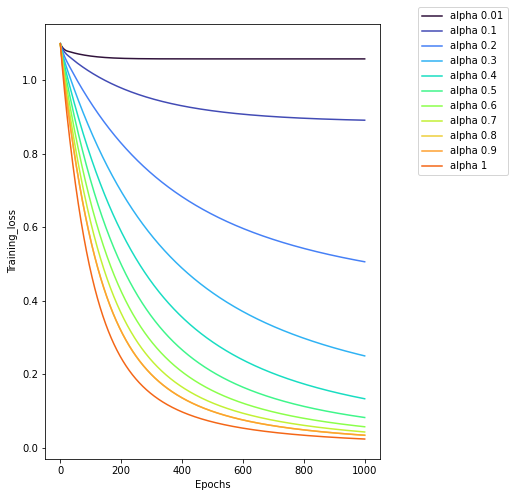

In [31]:
alpha = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="alpha "+str(alpha[i]),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))

Text(0.5, 1.0, 'alpha_=alpha+0.01')

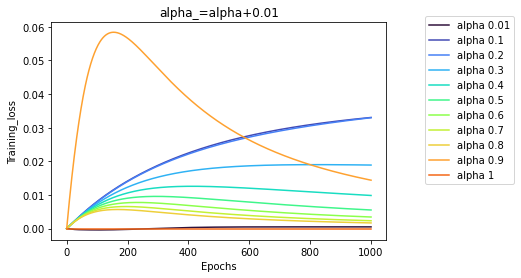

In [32]:
for i in range(len(train_loss_all)):
    temp = np.array(train_loss_all[i]) - np.array(train_loss_alpha_h_all[i])  
    plt.plot(temp,label ="alpha "+str(alpha[i]),color = cm(i*20))
    plt.xlabel("Epochs")
    plt.ylabel("Training_loss")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("alpha_=alpha+0.01")

In [33]:
# np.array(train_loss_all[9]) - np.array(train_loss_alpha_h_all[9])

In [34]:
# train_loss_alpha_h_all[0]

[1.0986122886681093,
 1.0969097019158804,
 1.0952986233655682,
 1.0937796632743155,
 1.0923528439619619,
 1.09101748488419,
 1.0897720919518776,
 1.0886142765205813,
 1.0875407412743683,
 1.0865473731941755,
 1.0856294662411328,
 1.0847820538700501,
 1.0840002795139756,
 1.0832797046506644,
 1.0826164729241783,
 1.082007304791329,
 1.0814493544546482,
 1.0809399908577726,
 1.0804765643420022,
 1.0800562042205124,
 1.0796756743063887,
 1.079331299948973,
 1.0790189713740614,
 1.0787342212990896,
 1.0784723674075474,
 1.0782287017468426,
 1.077998701165647,
 1.0777782285692246,
 1.0775636965166544,
 1.0773521726839073,
 1.077141418554349,
 1.0769298647294652,
 1.0767165354874273,
 1.0765009403730492,
 1.0762829519333321,
 1.0760626871741508,
 1.0758404068262668,
 1.0756164416925302,
 1.0753911496782447,
 1.0751649012213336,
 1.0749380856983657,
 1.074711128100882,
 1.0744845046748743,
 1.074258748377134,
 1.0740344391493284,
 1.0738121788233401,
 1.0735925546306857,
 1.0733760979221314,


In [35]:
# train_loss_all[0]

[1.0986122886681093,
 1.096898252992255,
 1.095275731169462,
 1.093745340739598,
 1.0923071119555343,
 1.0909603728930184,
 1.0897036388103565,
 1.0885345311835966,
 1.0874497636436826,
 1.0864452350075993,
 1.0855162520332522,
 1.0846578620070806,
 1.0838652232918142,
 1.0831339134262858,
 1.0824600932318766,
 1.0818405013831507,
 1.0812723112011977,
 1.0807529114494634,
 1.080279672737864,
 1.0798497447987945,
 1.0794599116774213,
 1.0791065183967634,
 1.0787854739004792,
 1.0784923282549772,
 1.07822241470987,
 1.07797103870023,
 1.0777336879289978,
 1.0775062333306133,
 1.0772850924589497,
 1.0770673348361464,
 1.0768507206282938,
 1.0766336760371527,
 1.076415218025565,
 1.0761948461460542,
 1.075972420570717,
 1.0757480438812845,
 1.0755219606910906,
 1.075294484355033,
 1.0750659543547063,
 1.0748367220620285,
 1.0746071574463436,
 1.0743776660114874,
 1.0741487046515932,
 1.0739207872793788,
 1.0736944752314839,
 1.073470352270801,
 1.0732489881664513,
 1.0730308974656124,
 1.0